In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

def mark_sequences(binary_array, k):
    count = 0
    start_index = None
    for i in range(len(binary_array)):
        if binary_array[i] == 1:
            if count == 0:
                start_index = i
            count += 1
        else:
            if count > 0:
                if count > k:
                    binary_array[start_index:start_index+k-1] = 0  # delete all 1s before the kth one
                    binary_array[start_index+k:i] = 0  # delete all 1s after the kth one
                else:
                    binary_array[start_index:i] = 0  # delete all 1s in the sequence
            count = 0
            start_index = None
    # Handle the last sequence of 1s
    if count > 0:
        if count > k:
            binary_array[start_index:start_index+k-1] = 0  # delete all 1s before the kth one
            binary_array[start_index+k:] = 0  # delete all 1s after the kth one
        else:
            binary_array[start_index:] = 0
    return binary_array


def eval(predictions, targets, k=None):
    thresholds = np.arange(0, 1, 0.01).tolist()

    precisions = []
    recalls = []
    specificities = []
    fpr_ls = []


    for threshold in thresholds:
        out = []
        ground_truth = []
        for i in range(predictions.shape[0]):

            target = targets[i]
            predicted = predictions[i]

            predicted_thresholded = (predicted > threshold).astype(int)

            last_index = np.where(target == 100000.0)[0]
            if last_index.size != 0:
                last_index = last_index[0]
                target = target[:last_index]
            else:
                last_index = None

            assert np.sum(target == 100000.0) == 0

            if k != None:
                predicted_thresholded = mark_sequences(predicted_thresholded, k)

            #predicted_thresholded = predicted_thresholded[36:] # mute first two hours of predictions
            
            if np.sum(target == 1.0) > 0: # positive patient

                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                ground_truth.append(1)
                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)
            elif np.sum(target == 1.0) == 0: # negative patient
                ground_truth.append(0)
                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)

        
        if threshold == 0.5:
            print(confusion_matrix(ground_truth, out))
            print(classification_report(ground_truth, out))

        tn, fp, fn, tp = confusion_matrix(ground_truth, out).ravel()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)

        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        fpr_ls.append(1 - specificity)

    # Use a list comprehension to filter out pairs where either value is NaN
    filtered_pairs = [(x, y) for x, y in zip(precisions, recalls) if not (np.isnan(x) or np.isnan(y))]

    # Split the filtered pairs back into two lists
    precision_no_nan, recalls_no_nan = zip(*filtered_pairs)

    auroc = auc(fpr_ls, recalls)
    print("AUROC: " + str(auroc))

    auprc = auc(recalls_no_nan, precision_no_nan)
    print("AUPRC: " + str(auprc))

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # First subplot for the Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, marker='.')
    plt.xlabel('Recall')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    # Second subplot for the Receiver Operating Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr_ls, recalls, marker='.')
    plt.ylabel('Sensitivity (Recall / TPR)')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xlabel('1 - Specificity (FPR)')
    plt.title('Receiver Operating Curve')

    # Display the plots
    plt.tight_layout()
    plt.show()

    return precisions, recalls, specificities, fpr_ls

In [2]:
def alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls):

    recalls_target = [0.9, 0.8, 0.7, 0.6, 0.5]
    precisions_target = []
    median_onset = []

    for target_recall in recalls_target:

        closest_index = min(range(len(recalls)), key=lambda index: abs(recalls[index]-target_recall))
        thresholds = np.arange(0, 1, 0.01).tolist()
        target_threshold = thresholds[closest_index] # 0.45 is the threshold for 80% recall in this case
        target_threshold

        out = []
        ground_truth = []
        times_to_onset = []
        for i in range(len(final_patients)):

            target = targets[i]
            predicted = predictions[i]

            predicted_thresholded = (predicted > target_threshold).astype(int)

            last_index = np.where(target == 100000.0)[0]
            if last_index.size != 0:
                last_index = last_index[0]
                target = target[:last_index]
            else:
                last_index = None

            assert np.sum(target == 100000.0) == 0
            
            if np.sum(target == 1.0) > 0: # positive patient

                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                onset_index = int((labels_file[labels_file['patient_ID'] == final_patients[i]]['indices_to_onset'].values[0]))

                ground_truth.append(1)
                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                    earliest_alarm = np.argmax(predicted_thresholded == 1)
                    time_to_onset = onset_index - earliest_alarm
                    times_to_onset.append(time_to_onset/12)
                else:
                    out.append(0)
            elif np.sum(target == 1.0) == 0: # negative patient
                ground_truth.append(0)
                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)

        median_onset.append(times_to_onset)
        precisions_target.append(precisions[closest_index])

    precisions_target = [round(item, 2) for item in precisions_target]
    recalls_target = [round(item, 2) for item in recalls_target]

    median_to_plot = [np.median(item) for item in median_onset]

    # Zip the two lists and convert them to string for plotting
    x_values = list(map(str, zip(recalls_target, precisions_target)))
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(x_values, median_to_plot)
    plt.xlabel('(Recall, Precision) in %')
    plt.ylabel('Median Alarm Earliness in Hours')
    plt.title('Bar plot of Median Alarm Earliness against Recall and Precision')
    print(median_to_plot)
    
    x_values = list(map(str, zip(recalls_target, precisions_target)))
    plt.subplot(1, 2, 2)
    plt.boxplot(median_onset, showfliers=False)
    plt.xticks(range(1, len(x_values) + 1), x_values)
    plt.xlabel('(Recall, Precision) in %')
    plt.ylabel('First Alarm to Onset Time in Hours')
    plt.grid(True)

    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

    plt.title('Spread of First Alarm to Onset Time against Recall and Precision of Model, Respiratory Failure')
    plt.tight_layout()
    plt.show()

## KIDNEY - EICU

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/eicu/eicu/kidney/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv('/datasets/amelatur/eicu_labels/kidney_labels.csv')


print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   




(996, 1728, 1) (996, 1728, 1) (996,) (116956, 5)


### No K-aggregates (first alarm raised only)

[[661 169]
 [ 84  82]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       830
           1       0.33      0.49      0.39       166

    accuracy                           0.75       996
   macro avg       0.61      0.65      0.62       996
weighted avg       0.79      0.75      0.77       996

AUROC: 0.7192807374074611
AUPRC: 0.29471096029345856


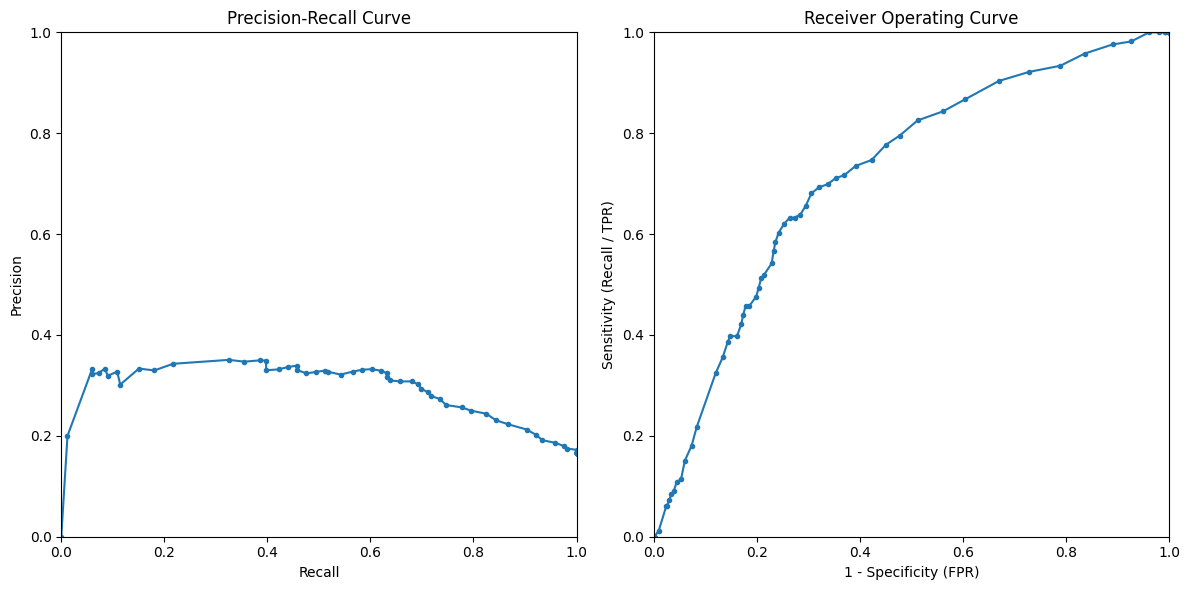

In [19]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 6 sequence (= 30 mins) ("aggregate")

[[618 237]
 [ 59 112]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81       855
           1       0.32      0.65      0.43       171

    accuracy                           0.71      1026
   macro avg       0.62      0.69      0.62      1026
weighted avg       0.81      0.71      0.74      1026

AUROC: 0.7286173523477308
AUPRC: 0.3250043318435605


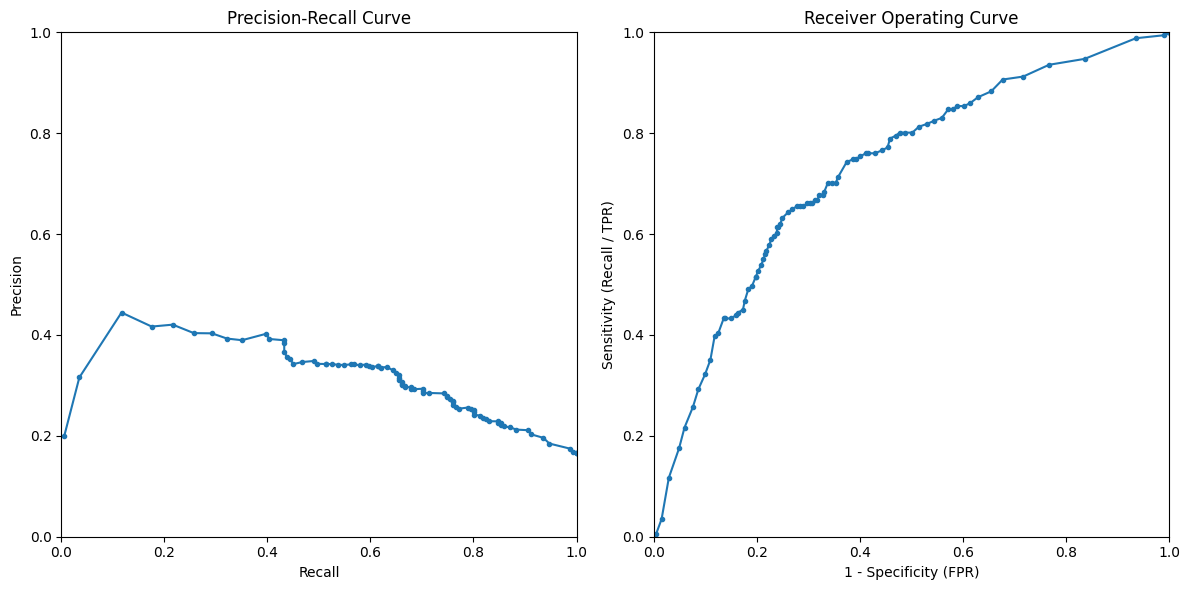

In [54]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 6)

### EARLIEST ALARM TO ONSET TIME

[12.833333333333334, 12.833333333333334, 11.708333333333332, 10.583333333333332, 11.333333333333332]


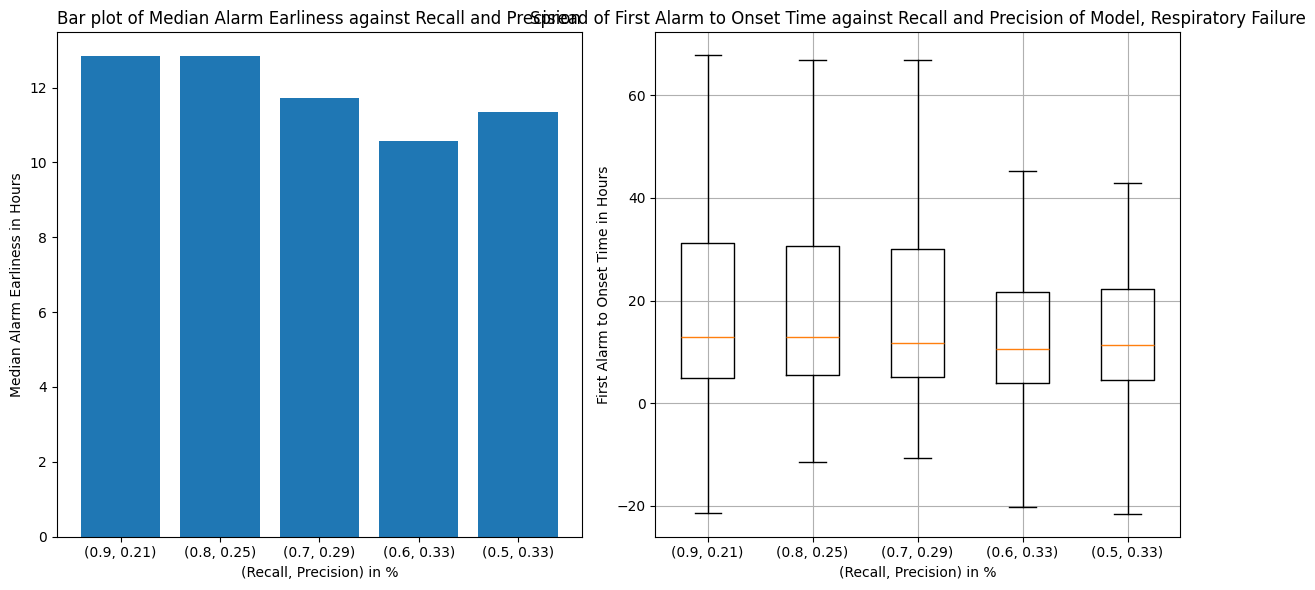

In [20]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)

## SHOCK - EICU

In [36]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/eicu/eicu/circulatory/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv('/datasets/amelatur/eicu_labels/circulatory_labels.csv')


print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   




(1001, 1728, 1) (1001, 1728, 1) (1001,) (116956, 5)


### No K-aggregates (first alarm raised only)

[[686 172]
 [ 51  92]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       858
           1       0.35      0.64      0.45       143

    accuracy                           0.78      1001
   macro avg       0.64      0.72      0.66      1001
weighted avg       0.85      0.78      0.80      1001

AUROC: 0.7906662102466299
AUPRC: 0.382648918781887


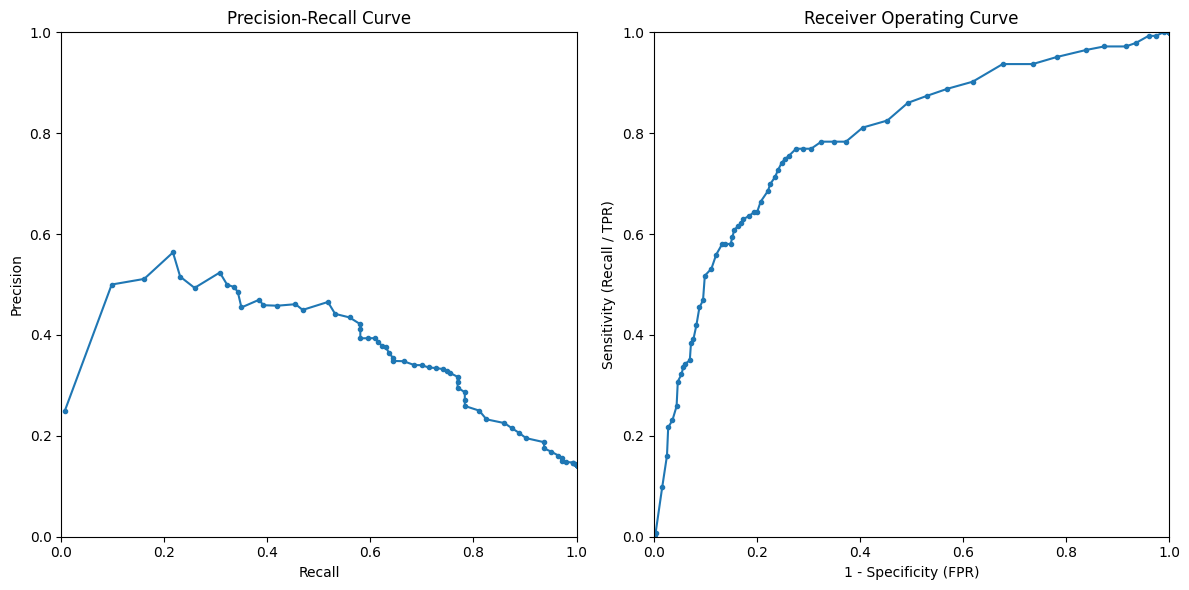

In [37]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 6 sequence (= 30 mins) ("aggregate")

[[791 133]
 [ 55  77]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       924
           1       0.37      0.58      0.45       132

    accuracy                           0.82      1056
   macro avg       0.65      0.72      0.67      1056
weighted avg       0.86      0.82      0.84      1056

AUROC: 0.80074691722419
AUPRC: 0.37159927148454974


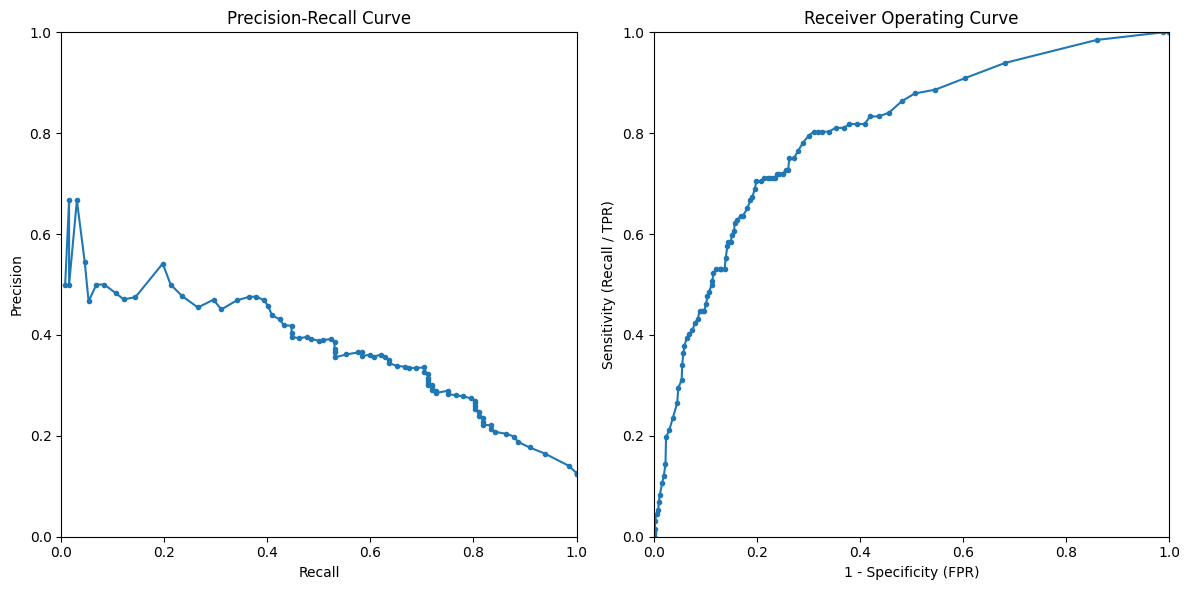

In [63]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 6)

### EARLIEST ALARM TO ONSET TIME

[6.958333333333334, 7.0, 6.958333333333334, 6.875, 5.25]


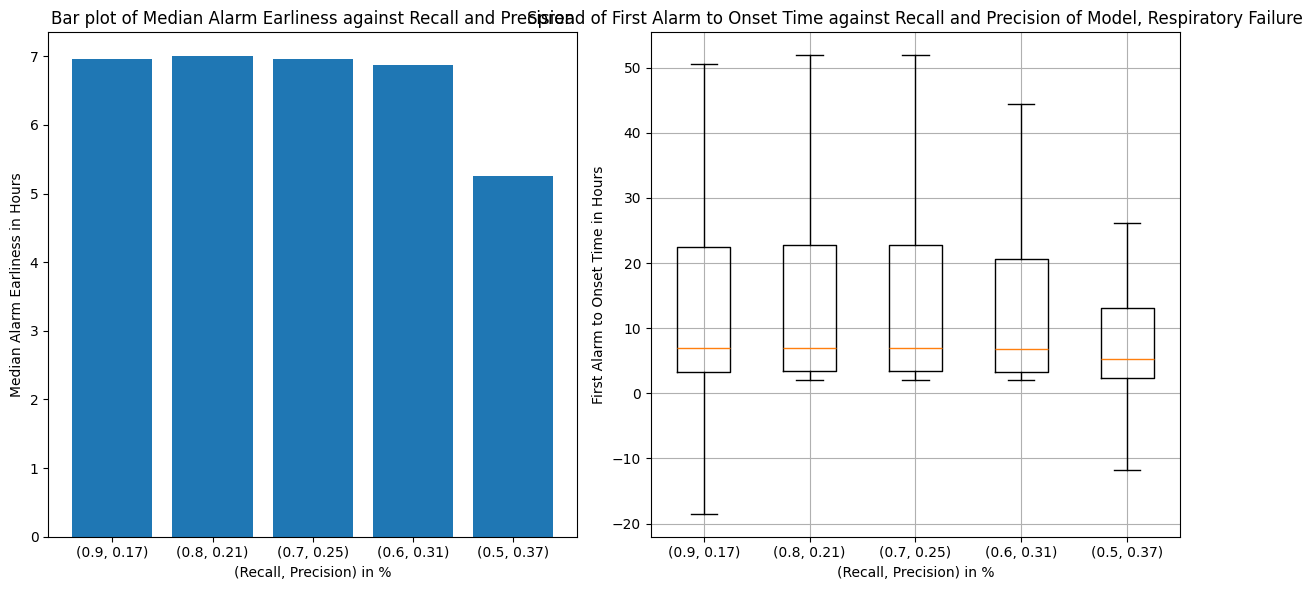

In [35]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)

## RESPIRATORY - EICU

In [55]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/eicu/eicu/respiratory_HiRID/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv('/datasets/amelatur/eicu_labels/respiratory_HiRID_labels.csv')


print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   




(910, 1728, 1) (910, 1728, 1) (910,) (116956, 5)


### No K-aggregates (first alarm raised only)

[[671 109]
 [ 60  70]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       780
           1       0.39      0.54      0.45       130

    accuracy                           0.81       910
   macro avg       0.65      0.70      0.67       910
weighted avg       0.84      0.81      0.83       910

AUROC: 0.7755078895463511
AUPRC: 0.35405808574432207


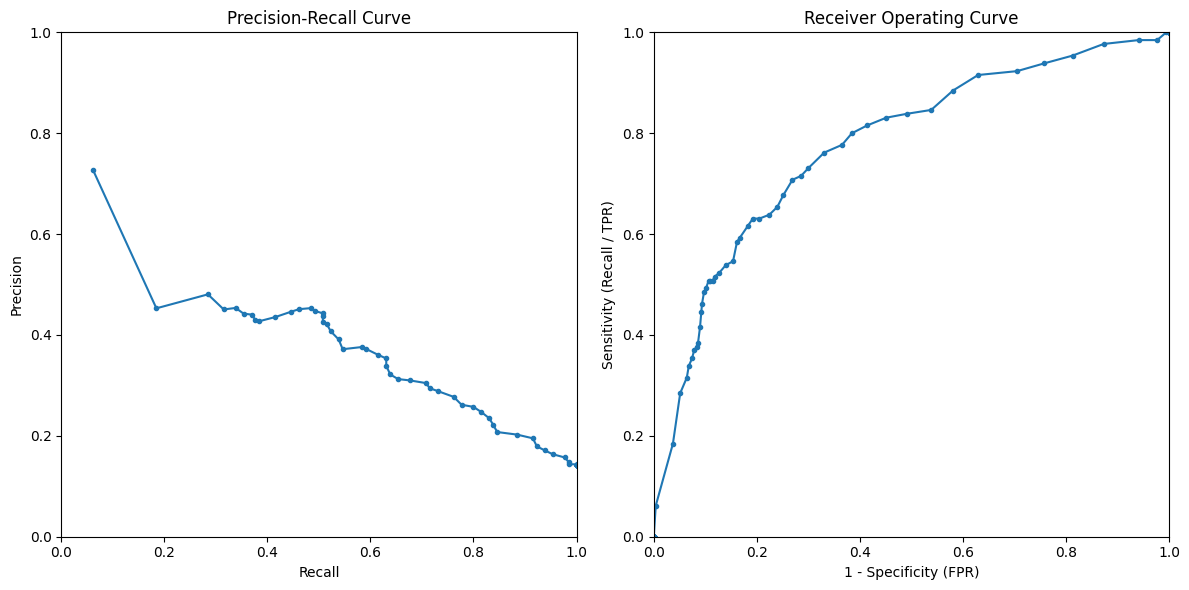

In [56]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 6 sequence (= 30 mins) ("aggregate")

In [54]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 6)

KeyboardInterrupt: 

### EARLIEST ALARM TO ONSET TIME

[8.166666666666666, 8.041666666666668, 8.541666666666666, 8.166666666666666, 8.083333333333334]


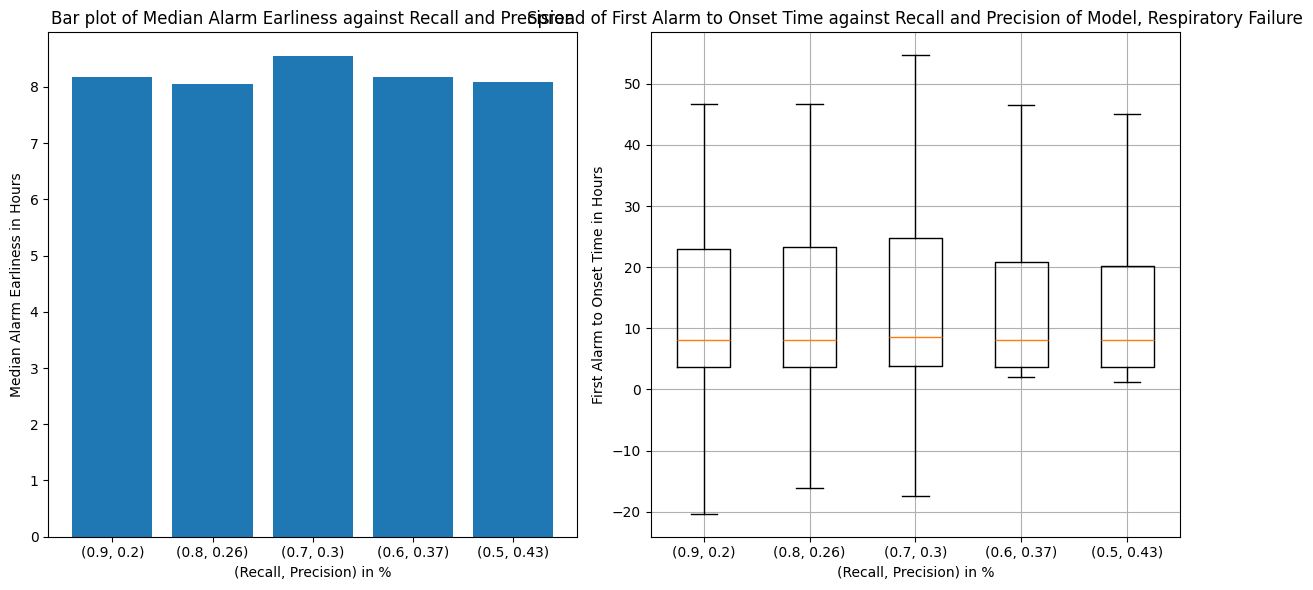

In [57]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)

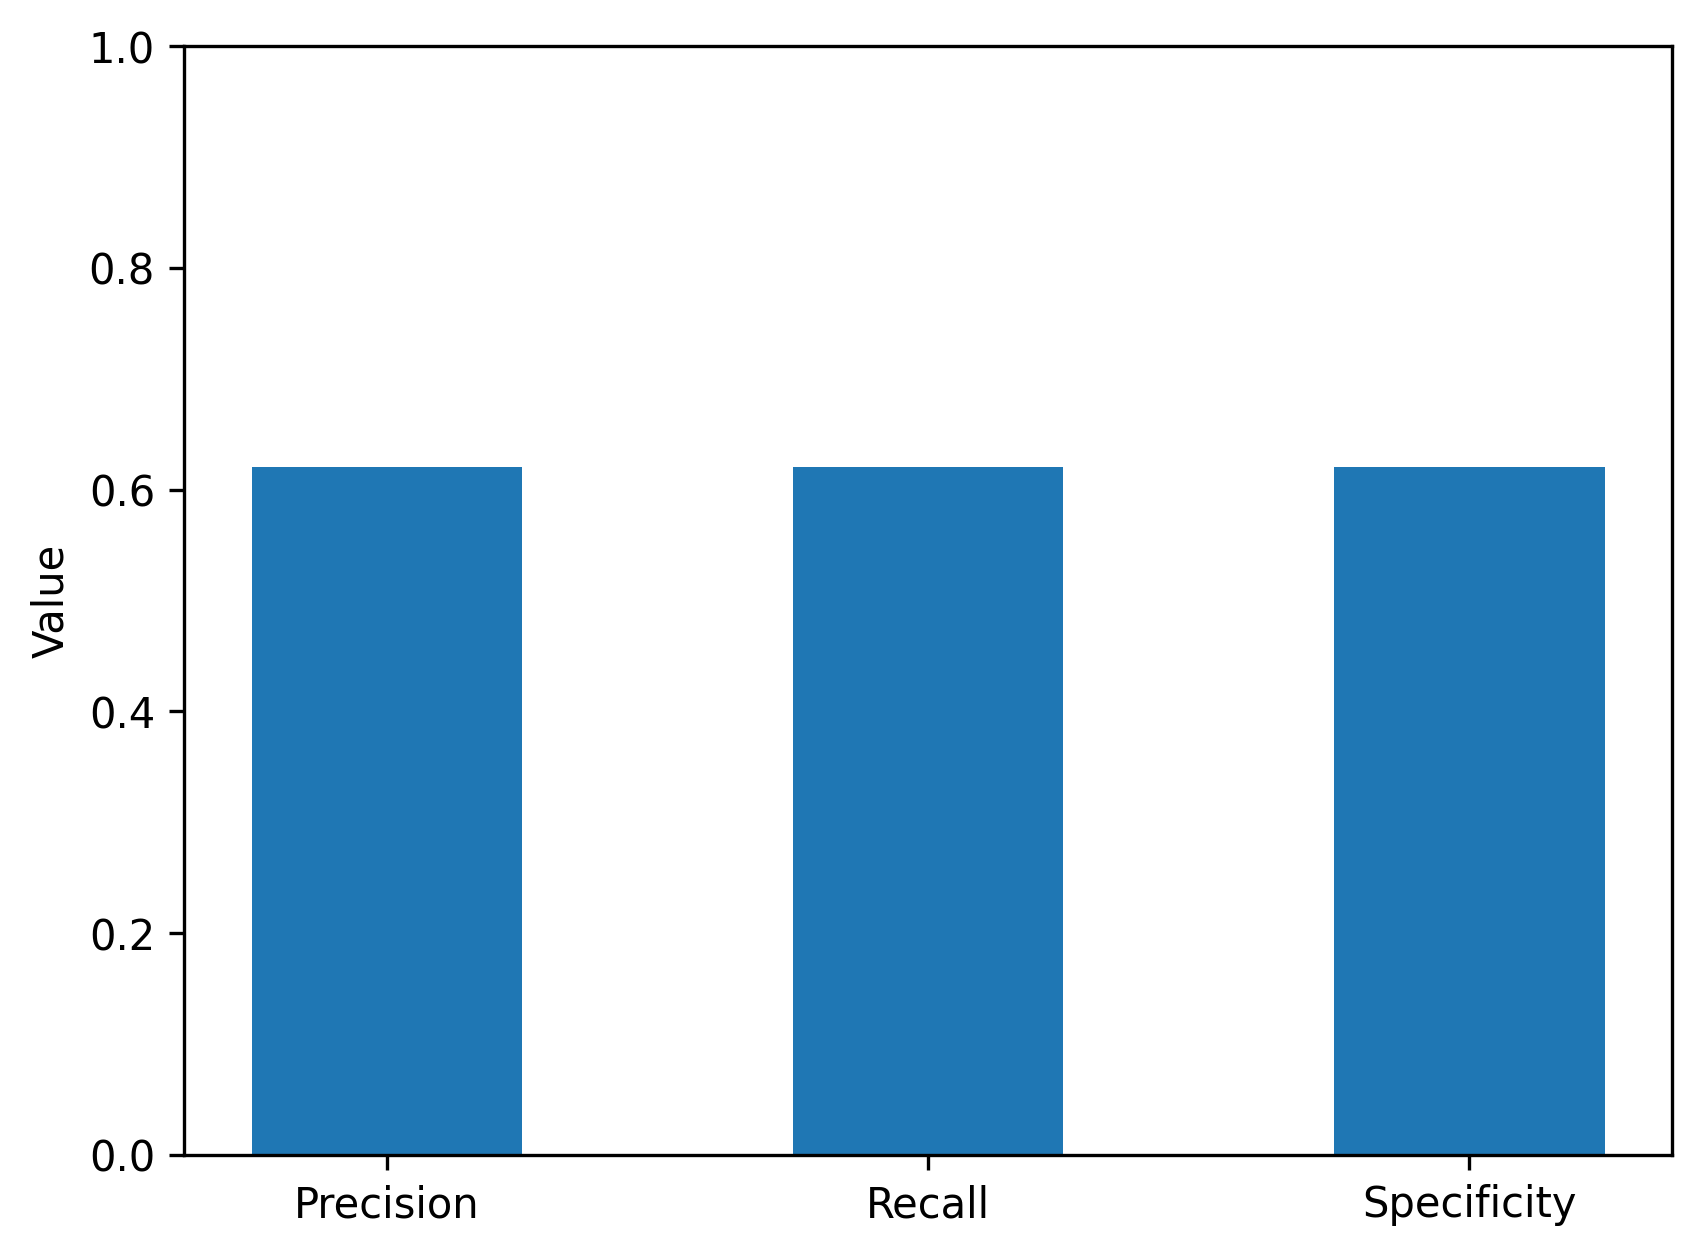

In [27]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import matplotlib.pyplot as plt
import numpy as np

# Values
precision = 0.62
recall = 0.62
specificity = 0.62

# Create a list of values and corresponding labels
values = [precision, recall, specificity]
labels = ['Precision', 'Recall', 'Specificity']

# Create array for positions of bars on x-axis
x_pos = np.arange(len(labels))

# Create bar plot with thinner bars and closer together
plt.bar(x_pos, values, width=0.5)  # adjust width as needed

# Replace the x ticks with the labels
plt.xticks(x_pos, labels)

# Add labels and title
plt.ylabel('Value')
plt.ylim([0, 1])

# Display the plot
plt.show()